In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
from torchmetrics import F1Score, Precision, Recall, ConfusionMatrix
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

/home/miguel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 2024
HIDDEN_SIZE = 128
BATCH_SIZE = 8
pl.seed_everything(seed)

Seed set to 2024


2024

In [3]:
#data_folder = os.path.join("results", 'activations.pkl')
#TASK = "binary"
#data_folder = os.path.join("results", 'activations_math.pkl')
data_folder = os.path.join("results", 'activations_st.pkl')
TASK = "multiclass"
with open(data_folder, 'rb') as file:
    db_activations_loaded = pickle.load(file)

In [4]:
# Let's determine the maximum size of the arrays
activation_shapes = [np.array(activation).shape for activation in db_activations_loaded['activations']]
max_size = max(activation_shapes)

# Function to pad arrays with zeros to the maximum size
def pad_with_zeros(array, size):
    return np.pad(array, (0, size - len(array)), mode='constant')

# Apply padding to all activations
padded_activations = [pad_with_zeros(np.array(activation), max_size[0]) for activation in db_activations_loaded['activations']]

# Replace the original activations with the padded ones
db_activations_loaded['activations'] = padded_activations

# Check the new shape of the first few activations to confirm the change
new_activation_shapes = [np.array(activation).shape for activation in db_activations_loaded['activations']]
print(set(new_activation_shapes))



{(4264960,)}


In [5]:
# Paso 1: Crear el Dataset personalizado
class ActivationDataset(Dataset):
    def __init__(self, activations, tasks):
        self.activations = torch.tensor(activations, dtype=torch.float32)
        self.tasks = torch.tensor(tasks, dtype=torch.long)  # asumiendo que las tareas son clases etiquetadas con enteros

    def __len__(self):
        return len(self.activations)

    def __getitem__(self, idx):
        return self.activations[idx], self.tasks[idx]
    

# Paso 2: Crear el DataLoader
def create_dataloaders(activations, tasks, batch_size=32, val_split=0.2):
    dataset = ActivationDataset(activations, tasks)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    print(f"Train dataset size: {len(train_dataset)}")
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    print(f"Validation dataset size: {len(val_dataset)}")
    
    return train_loader, val_loader

In [6]:
class MLPClassifier(pl.LightningModule):
    def __init__(self, input_size, num_classes, hidden_size=HIDDEN_SIZE):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
        # Métricas
        self.train_acc = torchmetrics.Accuracy(task=TASK, num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task=TASK, num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task=TASK, num_classes=num_classes)

        self.train_f1 = F1Score(num_classes=num_classes, average='macro', task=TASK)
        self.val_f1 = F1Score(num_classes=num_classes, average='macro', task=TASK)
        self.test_f1 = F1Score(num_classes=num_classes, average='macro', task=TASK)

        self.train_precision = Precision(num_classes=num_classes, average='macro', task=TASK)
        self.val_precision = Precision(num_classes=num_classes, average='macro', task=TASK)
        self.test_precision = Precision(num_classes=num_classes, average='macro', task=TASK)

        self.train_recall = Recall(num_classes=num_classes, average='macro', task=TASK)
        self.val_recall = Recall(num_classes=num_classes, average='macro', task=TASK)
        self.test_recall = Recall(num_classes=num_classes, average='macro', task=TASK)

        # Matriz de confusión para el conjunto de test
        self.conf_matrix = ConfusionMatrix(num_classes=num_classes, task=TASK)

        # Almacenará todas las predicciones y etiquetas
        self.preds = []
        self.targets = []

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # Training Step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Calcular métricas
        acc = self.train_acc(preds, y)
        f1 = self.train_f1(preds, y)
        precision = self.train_precision(preds, y)
        recall = self.train_recall(preds, y)

        # Log de métricas
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=False, on_epoch=True)
        self.log('train_recall', recall, on_step=False, on_epoch=True)

        return loss

    # Validation Step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Calcular métricas
        acc = self.val_acc(preds, y)
        f1 = self.val_f1(preds, y)
        precision = self.val_precision(preds, y)
        recall = self.val_recall(preds, y)

        # Log de métricas
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=False, on_epoch=True)
        self.log('val_recall', recall, on_step=False, on_epoch=True)

        return loss

    # Test Step (usar el mismo conjunto que validación para calcular los resultados)
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.preds.append(preds)
        self.targets.append(y)

        # Calcular métricas
        acc = self.test_acc(preds, y)
        f1 = self.test_f1(preds, y)
        precision = self.test_precision(preds, y)
        recall = self.test_recall(preds, y)

        # Actualizar la matriz de confusión
        self.conf_matrix_result = self.conf_matrix(preds, y)

        # Log de métricas
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_f1', f1, on_step=False, on_epoch=True)
        self.log('test_precision', precision, on_step=False, on_epoch=True)
        self.log('test_recall', recall, on_step=False, on_epoch=True)

        return loss
    
    def plot_cm(self):
        # Concatenar todas las predicciones y etiquetas
        preds = torch.cat(self.preds).cpu()
        targets = torch.cat(self.targets).cpu()

        # Calcular la matriz de confusión
        conf_matrix = self.conf_matrix(preds, targets).cpu().numpy()

        # Mostrar la matriz de confusión
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Matriz de Confusión')
        plt.show()

    # Optimizer configuration
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [7]:
# Paso 4: Crear el DataLoader y entrenar el modelo
# Supongamos que las activations y tasks ya están cargadas como listas de NumPy y listas de etiquetas
activations = db_activations_loaded['activations']  # Lista de activaciones (rellenas)
tasks = db_activations_loaded['task']  # Lista de tareas/clasificaciones

# Convertir tasks a enteros si no lo están ya (asegurarse de que las clases son números)
task_mapping = {label: idx for idx, label in enumerate(set(tasks))}  # Un mapeo de etiquetas a números
tasks = [task_mapping[task] for task in tasks]  # Convertir tareas a índices numéricos

# Crear DataLoader
train_loader, val_loader = create_dataloaders(activations, tasks, batch_size=BATCH_SIZE)

# Definir el modelo
input_size = len(activations[0])  # El tamaño del vector de entrada
num_classes = len(task_mapping)  # El número de clases

Train dataset size: 120
Validation dataset size: 30


/tmp/ipykernel_43383/2967417801.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  self.activations = torch.tensor(activations, dtype=torch.float32)


In [8]:
model = MLPClassifier(input_size=input_size, num_classes=num_classes)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/miguel/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matm

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s]

/home/miguel/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


/home/miguel/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/miguel/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 15/15 [00:01<00:00, 10.51it/s, v_num=6, val_loss=7.150, val_acc=0.833, val_f1=0.656, train_loss=3.64e-7, train_acc=1.000, train_f1=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s, v_num=6, val_loss=7.150, val_acc=0.833, val_f1=0.656, train_loss=3.64e-7, train_acc=1.000, train_f1=1.000]


In [10]:
trainer.test(model, dataloaders=val_loader) #cmd

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/miguel/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 38.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8333333134651184     │
│          test_f1          │    0.6558024883270264     │
│         test_loss         │     7.151209831237793     │
│      test_precision       │    0.7022221684455872     │
│        test_recall        │    0.6562963724136353     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 7.151209831237793,
  'test_acc': 0.8333333134651184,
  'test_f1': 0.6558024883270264,
  'test_precision': 0.7022221684455872,
  'test_recall': 0.6562963724136353}]

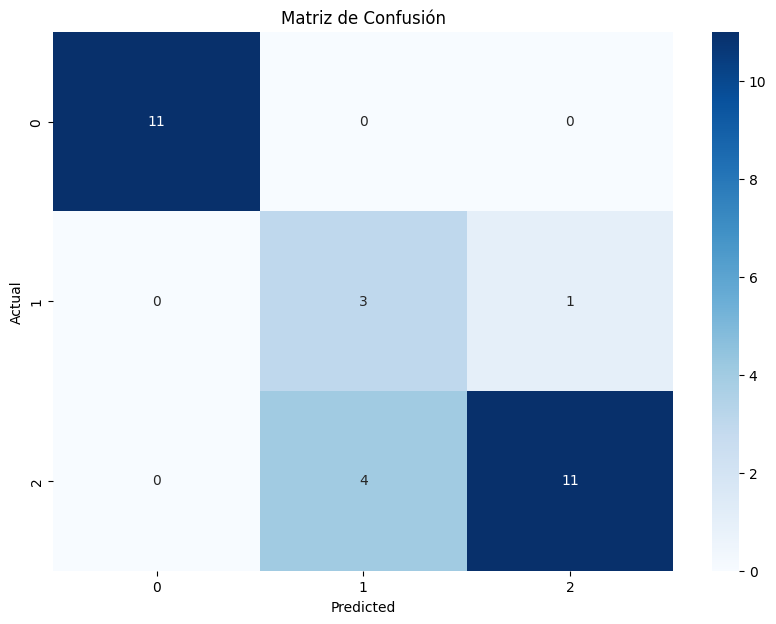

In [11]:
model.plot_cm()